In [3]:
#@title 1. Gerekli Kütüphanelerin Kurulumu ve Import Edilmesi
!pip install requests beautifulsoup4 pandas --quiet
import requests
from bs4 import BeautifulSoup
import json
import os
from urllib.parse import quote_plus
from google.colab import files
import time

In [4]:
#@title 2. Scraper Fonksiyonları ve Ayarları (Kitapyurdu için - 100 Yorum Limitiyle)
ARAMA_SONUC_LINK_SELECTOR = "div.product-cr .name a"
YORUMLAR_SAYFASI_LINK_SELECTOR = "a#reviews-tab-button"
KITAP_ADI_SELECTOR = "h1.pr_pro_name"
YORUM_KUTUSU_SELECTOR = "div.review-details"
KULLANICI_ADI_SELECTOR = "span[itemprop='name']"
YORUM_METNI_SELECTOR = "div[itemprop='reviewBody']"
DOLU_YILDIZ_SELECTOR = "i.sprite__product--star-selected"
SONRAKI_SAYFA_SELECTOR = "a.next"

def find_book_url_kitapyurdu(book_name):
    search_query = quote_plus(book_name)
    search_url = f"https://www.kitapyurdu.com/index.php?route=product/search&filter_name={search_query}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    print(f"'{book_name}' için Kitapyurdu'nda arama yapılıyor: {search_url}")
    try:
        response = requests.get(search_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        first_result_link_tag = soup.select_one(ARAMA_SONUC_LINK_SELECTOR)

        if first_result_link_tag and first_result_link_tag.get('href'):
            book_url = first_result_link_tag.get('href')
            print(f"Kitap bulundu: {book_url}")
            return book_url
        else:
            print(f"Arama sonucunda '{book_name}' için bir kitap bulunamadı.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Arama sırasında hata oluştu: {e}")
        return None

def get_reviews_from_kitapyurdu(book_url, max_reviews=100):
    """
    Belirtilen URL'den en fazla 'max_reviews' kadar yorum çeker.
    """
    if not book_url:
        return None

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    try:
        print(f"Kitap ana sayfasına gidiliyor: {book_url}")
        response = requests.get(book_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        kitap_adi_tag = soup.select_one(KITAP_ADI_SELECTOR)
        kitap_adi = kitap_adi_tag.text.strip() if kitap_adi_tag else "Kitap Adı Bulunamadı"
        print(f"Kitap Adı: {kitap_adi}")

        product_id_tag = soup.select_one("input[name='product_id']")
        if product_id_tag and product_id_tag.get('value'):
            product_id = product_id_tag.get('value')
            next_page_url = f"https://www.kitapyurdu.com/index.php?route=product/product/review&product_id={product_id}"
            print(f"Yorumlar sayfasına gidiliyor: {next_page_url}")
        else:
            print("Yorumlar sayfası için product_id bulunamadı. Proje sonlandırılıyor.")
            return None

        all_reviews = []
        page_count = 1

        while next_page_url:
            print(f"{page_count}. yorum sayfası işleniyor...")
            time.sleep(1)

            response = requests.get(next_page_url, headers=headers)
            if response.status_code != 200:
                print(f"Yorum sayfası {next_page_url} yüklenemedi. Durum Kodu: {response.status_code}")
                break

            current_soup = BeautifulSoup(response.content, 'html.parser')

            review_boxes = current_soup.select(YORUM_KUTUSU_SELECTOR)
            if not review_boxes:
                print("Bu sayfada yorum kutusu bulunamadı, döngü sonlandırılıyor.")
                break

            for box in review_boxes:
                # LİMİT KONTROLÜ
                if len(all_reviews) >= max_reviews:
                    print(f"İstenen yorum limitine ({max_reviews}) ulaşıldı. Çekme işlemi durduruluyor.")
                    break

                user_tag = box.select_one(KULLANICI_ADI_SELECTOR)
                user = user_tag.text.strip() if user_tag else "Bilinmiyor"

                text_tag = box.select_one(YORUM_METNI_SELECTOR)
                review_text = text_tag.text.strip() if text_tag else ""

                stars = box.select(DOLU_YILDIZ_SELECTOR)
                rating = len(stars)

                if len(review_text) > 20:
                    all_reviews.append({"kullanici": user, "puan": rating, "yorum": review_text})

            # === LİMİT KONTROLÜ EKLENDİ ===
            if len(all_reviews) >= max_reviews:
                break # Dıştaki while döngüsünü de kır

            next_page_tag = current_soup.select_one(SONRAKI_SAYFA_SELECTOR)
            if next_page_tag and next_page_tag.get('href'):
                next_page_url = next_page_tag.get('href')
                print(f"Sonraki sayfa bulundu: {next_page_url}")
                page_count += 1
            else:
                print("Sonraki yorum sayfası bulunamadı.")
                next_page_url = None

        print(f"Toplam {len(all_reviews)} adet yorum çekildi.")
        return {"kitap_adi": kitap_adi, "yorumlar": all_reviews}

    except requests.exceptions.RequestException as e:
        print(f"Yorumlar çekilirken hata oluştu: {e}")
        return None
    except Exception as e_gen:
        print(f"Genel bir hata oluştu: {e_gen}")
        import traceback
        traceback.print_exc()
        return None


def save_to_json(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Veriler başarıyla '{filename}' dosyasına kaydedildi.")

In [5]:
#@title 3. Ana İşlem Bloğu

user_book_name = input("Yorumlarını çekmek istediğiniz kitabın adını girin (Kitapyurdu): ")

if user_book_name:
    book_page_url = find_book_url_kitapyurdu(user_book_name)

    if book_page_url:
        book_data = get_reviews_from_kitapyurdu(book_page_url)

        if book_data and book_data.get("yorumlar"):
            safe_filename = "".join([c for c in user_book_name if c.isalpha() or c.isdigit() or c==' ']).strip()
            if not safe_filename:
                safe_filename = "kitap"
            output_filename = f"{safe_filename.replace(' ', '_').lower()}_kitapyurdu_yorumlari.json"
            save_to_json(book_data, output_filename)
            print(f"Oluşturulan '{output_filename}' dosyası bilgisayarınıza indiriliyor...")
            files.download(output_filename)
        else:
            print("Bu kitap için hiç yorum işlenemedi veya veri çekilemedi.")
    else:
        print(f"'{user_book_name}' için Kitapyurdu'nda geçerli bir kitap sayfası bulunamadı.")
else:
    print("Lütfen bir kitap adı girin.")

Yorumlarını çekmek istediğiniz kitabın adını girin (Kitapyurdu): Martin Eden
'Martin Eden' için Kitapyurdu'nda arama yapılıyor: https://www.kitapyurdu.com/index.php?route=product/search&filter_name=Martin+Eden
Kitap bulundu: https://www.kitapyurdu.com/kitap/martin-eden/346884.html&filter_name=Martin+Eden
Kitap ana sayfasına gidiliyor: https://www.kitapyurdu.com/kitap/martin-eden/346884.html&filter_name=Martin+Eden
Kitap Adı: Kitap Adı Bulunamadı
Yorumlar sayfasına gidiliyor: https://www.kitapyurdu.com/index.php?route=product/product/review&product_id=346884
1. yorum sayfası işleniyor...
Sonraki sayfa bulundu: https://www.kitapyurdu.com/index.php?route=product/product/review&page=2&product_id=346884
2. yorum sayfası işleniyor...
Sonraki sayfa bulundu: https://www.kitapyurdu.com/index.php?route=product/product/review&page=3&product_id=346884
3. yorum sayfası işleniyor...
Sonraki sayfa bulundu: https://www.kitapyurdu.com/index.php?route=product/product/review&page=4&product_id=346884
4. y

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
#@title Adım 2.1: Gerekli Kütüphanelerin Kurulumu (Analiz İçin)

# Hugging Face'in transformers kütüphanesini ve PyTorch'u yüklüyoruz.
!pip install transformers torch sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.5 MB/s eta 0:00:00


In [7]:
#@title Adım 2.2: Duygu Analizi Modelini Yükleme

import pandas as pd
import json
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
model_adi = "savasy/bert-base-turkish-sentiment-cased"

try:


    # "sentiment-analysis" pipeline'ını belirtilen modelle kuruyoruz.
    sentiment_pipeline = pipeline("sentiment-analysis", model=model_adi)

except Exception as e:
    print(f"\n Hata: Model yüklenirken bir sorun oluştu: {e}")
    sentiment_pipeline = None

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Bir önceki adımda oluşturulan 'martin_eden_kitapyurdu_yorumlari.json' dosyası analiz için kullanılacak.
100 adet yorum dosyadan okundu.

Toplam 100 yorum için batch duygu analizi yapılıyor

--- DUYGU ANALİZİ SONUÇLARI (İlk 5 Yorum) ---
   puan duygu_etiketi  duygu_skoru  \
0     5       Pozitif     0.996077   
1     5       Pozitif     0.995454   
2     5       Pozitif     0.996450   
3     5       Pozitif     0.986217   
4     5       Negatif     0.836103   

                                               yorum  
0  Sosyal medya uygulamalarında kitapseverler içi...  
1  Evet sevgili Martin, söyle bakalım tam olarak ...  
2  Martin Eden… Aklınızın bir köşesine kazınacak ...  
3  Çok akıcı.Dönemine yazarına ayna tutuyor.Eseri...  
4  yazar olmaya ve zengin burjuva sınıfına dahil ...  

--- GENEL DUYGU DAĞILIMI ---
duygu_etiketi
Pozitif    88
Negatif    12
Name: count, dtype: int64


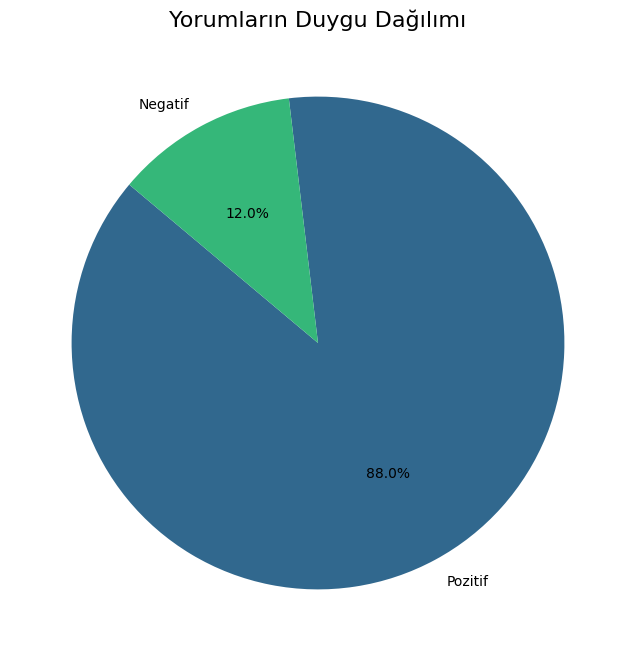

In [8]:
#@title Adım 2.3: JSON Dosyasını Okuma ve Yorumları Analiz Etme (Otomatik Dosya Adı ile - BATCH DESTEKLİ)

if 'output_filename' in locals() and output_filename:
    json_dosya_adi = output_filename
    print(f"Bir önceki adımda oluşturulan '{json_dosya_adi}' dosyası analiz için kullanılacak.")
else:
    print("HATA: Analiz edilecek dosya adı bulunamadı. Lütfen bir önceki 'Ana İşlem Bloğu' hücresini çalıştırdığınızdan emin olun.")
    json_dosya_adi = None

if json_dosya_adi and 'sentiment_pipeline' in locals() and sentiment_pipeline is not None:
    try:
        with open(json_dosya_adi, 'r', encoding='utf-8') as f:
            data = json.load(f)

        df_reviews = pd.DataFrame(data['yorumlar'])
        print(f"{len(df_reviews)} adet yorum dosyadan okundu.")

        df_reviews = df_reviews[df_reviews['yorum'].str.len() > 20].reset_index(drop=True)

        if not df_reviews.empty:
            yorumlar_listesi = df_reviews['yorum'].tolist()
            print(f"\nToplam {len(yorumlar_listesi)} yorum için batch duygu analizi yapılıyor")


            batch_size = 16
            sentiment_results = []

            for i in range(0, len(yorumlar_listesi), batch_size):
                batch = yorumlar_listesi[i:i + batch_size]
                try:
                    sentiment_results.extend(sentiment_pipeline(batch))
                except Exception as e:
                    print(f"Batch {i}-{i+batch_size} hata verdi: {e}")
                    sentiment_results.extend([{"label": "neutral", "score": 0.0}] * len(batch))

            df_reviews['duygu_etiketi'] = [result['label'] for result in sentiment_results]
            df_reviews['duygu_skoru'] = [result['score'] for result in sentiment_results]

            label_map = {'positive': 'Pozitif', 'negative': 'Negatif', 'neutral': 'Nötr'}
            df_reviews['duygu_etiketi'] = df_reviews['duygu_etiketi'].map(label_map)

            print("\n--- DUYGU ANALİZİ SONUÇLARI (İlk 5 Yorum) ---")
            print(df_reviews[['puan', 'duygu_etiketi', 'duygu_skoru', 'yorum']].head())

            print("\n--- GENEL DUYGU DAĞILIMI ---")
            duygu_dagilimi = df_reviews['duygu_etiketi'].value_counts()
            print(duygu_dagilimi)

            plt.figure(figsize=(8, 8))
            plt.pie(duygu_dagilimi, labels=duygu_dagilimi.index, autopct='%1.1f%%', startangle=140,
                    colors=sns.color_palette("viridis", len(duygu_dagilimi)))
            plt.title("Yorumların Duygu Dağılımı", fontsize=16)
            plt.ylabel('')
            plt.show()
        else:
            print("Analiz edilecek yeterli uzunlukta yorum bulunamadı.")
    except FileNotFoundError:
        print(f"\n HATA: '{json_dosya_adi}' dosyası bulunamadı. Lütfen dosya adını kontrol edin veya dosyayı Colab'a yükleyin.")
    except Exception as e:
        print(f"Dosya okunurken veya analiz sırasında bir hata oluştu: {e}")
else:
    print("Duygu analizi modeli yüklenemediği için işlem yapılamıyor. Lütfen bir önceki model yükleme hücresini çalıştırın.")


In [13]:
#@title Adım 2.4: Gelişmiş Olumlu ve Olumsuz Anahtar Kelime Çıkarımı

from collections import Counter, defaultdict
import nltk
import re
import pandas as pd
from textblob import TextBlob
import numpy as np


try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    from nltk.corpus import stopwords
except Exception as e:
    print(f"NLTK veri paketi indirilirken hata: {e}")
    stopwords = set()

class AdvancedKeywordAnalyzer:
    def __init__(self, book_name=None, author_names=None, character_names=None):
        self.book_name = book_name
        self.author_names = author_names or []
        self.character_names = character_names or []
        self.turkce_stop_words = set(stopwords.words('turkish')) if stopwords else set()
        self.detected_names = set()  # Otomatik tespit edilen isimler

        # İlk başta boş stop_words oluştur, sonra setup ile doldur
        self.stop_words = set()
        self.setup_stop_words()

    def setup_stop_words(self):
        """Genişletilmiş stopword listesi"""
        # Temel Türkçe stopwords
        additional_turkish_stops = {
            # Zamir ve bağlaçlar
            "ben", "sen", "o", "biz", "siz", "onlar", "bu", "şu", "bunlar", "şunlar",
            "kendi", "kendisi", "kendimi", "kendine", "kendini", "birisi", "herkes",
            "hiçbiri", "bazı", "birkaç", "tüm", "hep", "hemen", "artık", "henüz",

            # Kitap yorumu özel kelimeleri
            "kitap", "kitabı", "kitabın", "kitabını", "kitapta", "kitaptaki", "kitaplar",
            "yazar", "yazarın", "yazarı", "roman", "romanı", "romanın", "hikaye",
            "hikayesi", "karakter", "karakterler", "karakteri", "konu", "konusu",
            "sayfa", "sayfalar", "bölüm", "bölümler", "cümle", "cümleler",
            "okuma", "okudum", "okuyor", "okumak", "okuyucu", "okurken",

            # Değerlendirme ifadeleri
            "bence", "sanki", "gibi", "kadar", "şekilde", "açısından", "bakımından",
            "olarak", "şöyle", "böyle", "nasıl", "neden", "niçin", "niye", "madem",

            # Sık kullanılan sıfat/zarflar
            "çok", "çok", "pek", "oldukça", "epey", "hayli", "fazla", "az", "biraz",
            "daha", "en", "çok", "az", "büyük", "küçük", "iyi", "kötü", "güzel",
            "berbat", "mükemmel", "normal", "sıradan", "özel", "farklı", "aynı",

            # Zaman belirteçleri
            "önce", "sonra", "şimdi", "bugün", "dün", "yarın", "daima", "hep",
            "hiç", "bazen", "ara", "sıra", "zaman", "vakit", "süre", "dönem",

            # Genel ifadeler
            "şey","bir","çok","kadar","daha","şeyi", "şeyler", "durum", "hal", "olay", "mesele", "konu",
            "yer", "yeri", "taraf", "yan", "üst", "alt", "ara", "orta",
            "başka", "diğer", "öteki", "öbür", "her", "hiç", "tek", "çift"
        }

        # Kitap adını stopword'lara ekle
        if self.book_name:
            book_words = set(re.sub(r'[^\w\s]', '', self.book_name.lower()).split())
            additional_turkish_stops.update(book_words)

    def detect_names_automatically(self, df):
        """Yorumlardaki isimleri otomatik tespit et"""
        print("🔍 İsimler otomatik tespit ediliyor...")

        # Büyük harfle başlayan kelimeleri topla
        capitalized_words = Counter()

        for _, row in df.iterrows():
            text = str(row['yorum'])
            # Cümle başındaki kelimeleri hariç tut
            sentences = re.split(r'[.!?]+', text)

            for sentence in sentences:
                words = sentence.strip().split()
                # Cümle ortasındaki büyük harfli kelimeleri al
                for i, word in enumerate(words[1:], 1):  # İlk kelimeyi atla
                    clean_word = re.sub(r'[^\w]', '', word.lower())
                    if (word[0].isupper() and
                        len(clean_word) > 2 and
                        clean_word not in self.turkce_stop_words and
                        not clean_word.isdigit()):
                        capitalized_words[clean_word] += 1

        # Sık geçen büyük harfli kelimeleri isim olarak kabul et
        frequent_names = [word for word, count in capitalized_words.items()
                         if count >= 3]  # En az 3 kez geçmeli

        self.detected_names.update(frequent_names)

        if frequent_names:
            print(f"   Tespit edilen muhtemel isimler: {', '.join(frequent_names[:10])}")

        return frequent_names

    def preprocess_text(self, text):
        """Metin ön işleme"""
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Küçük harfe çevir
        text = text.lower()

        # Türkçe karakterleri koru, diğer özel karakterleri temizle
        text = re.sub(r'[^a-zçğıöşüA-ZÇĞIİÖŞÜ\s]', ' ', text)

        # Çoklu boşlukları tek boşluğa çevir
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_words(self, text):
        """Stopword'ları filtrele ve anlamlı kelimeleri çıkar"""
        processed_text = self.preprocess_text(text)
        words = [
            word for word in processed_text.split()
            if word not in self.stop_words and len(word) > 2
        ]
        return words

    def find_sentiment_keywords(self, df, sentiment_label, top_n=15, filter_names=True):
        """Belirtilen duygu için anahtar kelimeleri bul"""
        if df.empty:
            return [], {}

        # İlk çalıştırmada isimleri tespit et
        if filter_names and not self.detected_names:
            self.detect_names_automatically(df)
            # Stop words'ü yeniden oluştur
            self.setup_stop_words()

        # Sentiment'a göre filtrele
        sentiment_df = df[df['duygu_etiketi'] == sentiment_label]

        if sentiment_df.empty:
            return [], {}

        # Tüm yorumları birleştir
        all_text = " ".join(sentiment_df['yorum'].fillna(""))
        words = self.extract_words(all_text)

        # Kelime frekansları
        word_counts = Counter(words)

        # Ek filtreleme: çok kısa veya sayısal kelimeleri çıkar
        filtered_counts = Counter()
        for word, count in word_counts.items():
            if (len(word) >= 3 and
                not word.isdigit() and
                not any(char.isdigit() for char in word) and
                count >= 2):  # En az 2 kez geçmeli
                filtered_counts[word] = count

        # İstatistiksel bilgiler
        stats = {
            'toplam_yorum': len(sentiment_df),
            'toplam_kelime': len(words),
            'benzersiz_kelime': len(set(words)),
            'ortalama_kelime_per_yorum': len(words) / len(sentiment_df) if len(sentiment_df) > 0 else 0,
            'filtrelenen_kelime': len(word_counts) - len(filtered_counts)
        }

        return filtered_counts.most_common(top_n), stats

    def analyze_word_context(self, df, word, sentiment_label, max_examples=3):
        """Bir kelimenin kullanıldığı bağlamları analiz et"""
        sentiment_df = df[df['duygu_etiketi'] == sentiment_label]

        examples = []
        for _, row in sentiment_df.iterrows():
            yorum = str(row['yorum']).lower()
            if word in yorum:
                # Kelimenin geçtiği cümleyi bul
                sentences = re.split(r'[.!?]+', yorum)
                for sentence in sentences:
                    if word in sentence:
                        # Cümleyi temizle ve kısalt
                        clean_sentence = sentence.strip()
                        if len(clean_sentence) > 100:
                            # Kelime çevresindeki metni al
                            word_pos = clean_sentence.find(word)
                            start = max(0, word_pos - 50)
                            end = min(len(clean_sentence), word_pos + 50)
                            clean_sentence = "..." + clean_sentence[start:end] + "..."

                        examples.append(clean_sentence)
                        if len(examples) >= max_examples:
                            return examples

        return examples

    def compare_sentiments(self, df):
        """Pozitif ve negatif yorumları karşılaştır"""
        print("\n" + "="*25 + " DETAYLI ANALİZ RAPORU " + "="*25)

        # Her sentiment için analiz
        sentiments = ['Pozitif', 'Negatif', 'Nötr']
        results = {}

        for sentiment in sentiments:
            keywords, stats = self.find_sentiment_keywords(df, sentiment)
            results[sentiment] = {'keywords': keywords, 'stats': stats}

        # Sonuçları raporla
        for sentiment in sentiments:
            if not results[sentiment]['keywords']:
                continue

            stats = results[sentiment]['stats']
            keywords = results[sentiment]['keywords']

            emoji = {"Pozitif": "✅", "Negatif": "❌", "Nötr": "⚪"}[sentiment]

            print(f"\n{emoji} {sentiment.upper()} YORUMLAR ANALİZİ:")
            print(f"    Toplam Yorum: {stats['toplam_yorum']}")
            print(f"    Toplam Kelime: {stats['toplam_kelime']:,}")
            print(f"    Benzersiz Kelime: {stats['benzersiz_kelime']:,}")
            print(f"    Yorum Başına Ortalama Kelime: {stats['ortalama_kelime_per_yorum']:.1f}")

            print(f"\n    En Sık Kullanılan Kelimeler:")
            for i, (kelime, sayi) in enumerate(keywords[:10], 1):
                print(f"   {i:2d}. {kelime:<15} ({sayi:3d} kez)")

        # Sentiment karşılaştırması
        if results['Pozitif']['keywords'] and results['Negatif']['keywords']:
            self.sentiment_comparison_analysis(results)

    def sentiment_comparison_analysis(self, results):
        """Pozitif ve negatif sentiment'ları karşılaştır"""
        print(f"\n POZİTİF vs NEGATİF KARŞILAŞTIRMA:")

        # Sadece pozitif/negatif'te bulunan kelimeler
        pos_words = {word for word, _ in results['Pozitif']['keywords']}
        neg_words = {word for word, _ in results['Negatif']['keywords']}

        only_positive = pos_words - neg_words
        only_negative = neg_words - pos_words
        common_words = pos_words & neg_words

        if only_positive:
            print(f"\n   ✨ Sadece POZİTİF yorumlarda geçen kelimeler:")
            pos_dict = dict(results['Pozitif']['keywords'])
            for word in sorted(only_positive, key=lambda x: pos_dict[x], reverse=True)[:5]:
                print(f"   • {word} ({pos_dict[word]} kez)")

        if only_negative:
            print(f"\n    Sadece NEGATİF yorumlarda geçen kelimeler:")
            neg_dict = dict(results['Negatif']['keywords'])
            for word in sorted(only_negative, key=lambda x: neg_dict[x], reverse=True)[:5]:
                print(f"   • {word} ({neg_dict[word]} kez)")

        if common_words:
            print(f"\n    Her iki sentiment'ta da geçen kelimeler: {len(common_words)} adet")

    def generate_word_insights(self, df, top_words=5):
        """Anahtar kelimeler için içgörü analizi"""
        print(f"\n🔍 KELİME İÇGÖRÜ ANALİZİ:")

        for sentiment in ['Pozitif', 'Negatif']:
            keywords, _ = self.find_sentiment_keywords(df, sentiment, top_n=top_words)

            if not keywords:
                continue

            emoji = "✅" if sentiment == "Pozitif" else "❌"
            print(f"\n{emoji} {sentiment} Yorumlarda Kelime Bağlamları:")

            for kelime, sayi in keywords[:5]:  # İlk 3 kelime için
                print(f"\n    '{kelime}' kelimesi ({sayi} kez):")
                examples = self.analyze_word_context(df, kelime, sentiment, max_examples=2)
                for i, example in enumerate(examples, 1):
                    print(f"   {i}. \"{example}\"")



def run_advanced_analysis(author_names=None, character_names=None):
    """
    Gelişmiş analizi çalıştır

    Parameters:
    author_names: list - Yazar isimleri (örn: ["Sabahattin Ali", "Ali"])
    character_names: list - Karakter isimleri (örn: ["Ayşe", "Mehmet", "Zeynep"])
    """


    df = None


    if 'df_reviews' in globals():
        df = globals()['df_reviews']
    elif 'df_reviews' in locals():
        df = locals()['df_reviews']

    if df is None:
        print(" 'df_reviews' DataFrame bulunamadı!")
        print("Lütfen duygu analizi adımını önce çalıştırın.")
        return

    if df.empty:
        print(" DataFrame boş!")
        return


    kitap_adi = 'Bilinmeyen Kitap'
    if 'data' in globals() and isinstance(globals()['data'], dict):
        kitap_adi = globals()['data'].get('kitap_adi', 'Bilinmeyen Kitap')

    print(f"📚 KİTAP: {kitap_adi}")
    print(f"📊 TOPLAM YORUM: {len(df)}")

    # İsim filtreleme bilgisi
    if author_names or character_names:
        print(" MANUEL İSİM FİLTRELEME AKTİF:")
        if author_names:
            print(f"   Yazar isimleri: {', '.join(author_names)}")
        if character_names:
            print(f"   Karakter isimleri: {', '.join(character_names[:5])}{'...' if len(character_names) > 5 else ''}")
    else:
        print(" OTOMATİK İSİM TESPİTİ AKTİF")

    # Duygu dağılımı
    sentiment_counts = df['duygu_etiketi'].value_counts()
    print(f"DUYGU DAĞILIMI:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {sentiment}: {count} yorum (%{percentage:.1f})")


    analyzer = AdvancedKeywordAnalyzer(
        book_name=kitap_adi,
        author_names=author_names,
        character_names=character_names
    )
    analyzer.compare_sentiments(df)
    analyzer.generate_word_insights(df)

    print("\n" + "="*75)
    print(" ANALİZ TAMAMLANDI!")
    print("="*75)


#Farklı kullanım şekilleri:

# 1. Otomatik isim tespiti ile (varsayılan)
run_advanced_analysis()

# 2. Manuel yazar/karakter isimleri ile
# run_advanced_analysis(
#     author_names=["Orhan Pamuk", "Pamuk"],
#     character_names=["Kemal", "Füsun", "Sibel"]
# )

# 3. Sadece yazar ismi ile
# run_advanced_analysis(author_names=["Stefan Zweig"])

📚 KİTAP: Kitap Adı Bulunamadı
📊 TOPLAM YORUM: 100
 OTOMATİK İSİM TESPİTİ AKTİF
DUYGU DAĞILIMI:
   Pozitif: 88 yorum (%88.0)
   Negatif: 12 yorum (%12.0)

========================= DETAYLI ANALİZ RAPORU =========================
🔍 İsimler otomatik tespit ediliyor...
   Tespit edilen muhtemel isimler: jack, london, eden, martin, edenin, londonın, ruth

✅ POZITIF YORUMLAR ANALİZİ:
    Toplam Yorum: 88
    Toplam Kelime: 1,569
    Benzersiz Kelime: 901
    Yorum Başına Ortalama Kelime: 17.8

    En Sık Kullanılan Kelimeler:
    1. bir             ( 93 kez)
    2. çok             ( 44 kez)
    3. kitap           ( 32 kez)
    4. martin          ( 23 kez)
    5. eden            ( 19 kez)
    6. kadar           ( 17 kez)
    7. jack            ( 14 kez)
    8. london          ( 14 kez)
    9. daha            ( 13 kez)
   10. okuduğum        ( 12 kez)

❌ NEGATIF YORUMLAR ANALİZİ:
    Toplam Yorum: 12
    Toplam Kelime: 301
    Benzersiz Kelime: 221
    Yorum Başına Ortalama Kelime: 25.1

    E